In [80]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [81]:
rna_sequnce = ['ACT','GTU' , 'AUN']

In [82]:
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

x = []
for seq in rna_sequnce:
    x.append(encode_seq(seq))
x = torch.from_numpy( np.array(x))
x

tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=torch.int32)

In [83]:
labels = ['red','blue','green']
le = LabelEncoder()
y = le.fit_transform(labels)
y = torch.from_numpy(np.array(y))
y 

tensor([2, 0, 1])

# Single Directional LSTM

In [5]:
hidden_dim = 3
embedding_dim = 7
input_dim = 12

embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True )
fc = nn.Linear(hidden_dim, 3) 

In [6]:
embedding_out =  embedding(x)
print(embedding_out.shape)

torch.Size([3, 12, 7])


In [7]:
lstm_out , (h,c) = lstm(embedding_out)

print(h.shape)
h[-1] # In case of Bi Directional use both output

torch.Size([1, 3, 3])


tensor([[-0.0884, -0.0207,  0.2398],
        [-0.0889, -0.0208,  0.2397],
        [-0.0785,  0.0167,  0.1937]], grad_fn=<SelectBackward0>)

In [8]:
outputs = fc(h[-1])
outputs

tensor([[-0.1269,  0.3245, -0.6476],
        [-0.1269,  0.3247, -0.6477],
        [-0.1268,  0.3313, -0.6388]], grad_fn=<AddmmBackward0>)

In [9]:

_, predicted = torch.max(outputs,1)
predicted

tensor([1, 1, 1])

In [10]:
loss_function = nn.CrossEntropyLoss()
loss = loss_function(outputs, y)
loss.item()

1.1746009588241577

# Bi-Directional LSTM with Attention

In [84]:
hidden_dim = 3
embedding_dim = 7
input_dim = 4

b_embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
b_lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True , bidirectional=True )
b_fc = nn.Linear(hidden_dim, 3) 

In [85]:
b_embedding_out =  b_embedding(x)
print(b_embedding_out.shape)

torch.Size([3, 12, 7])


In [87]:
b_lstm_out , (h,c) = b_lstm(b_embedding_out)

#b_lstm_out , (h,c) = b_lstm(x)

print('Shape of h : ' , h)

#       [[[ 0.1242,  0.0155,  0.1971],
#          [ 0.1305,  0.0160,  0.2074],
#          [ 0.1432, -0.0180, -0.1529]],

#         [[ 0.0721, -0.3585, -0.2495],
#          [-0.0041, -0.4517, -0.1265],
#          [ 0.0710, -0.3557, -0.2356]]]

#b_h = torch.cat(h[-2:], dim=1)
b_h = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)

b_h

Shape of h :  tensor([[[-0.0891,  0.1734,  0.2396],
         [-0.0882,  0.1732,  0.2407],
         [-0.0251,  0.1378,  0.1418]],

        [[-0.0999, -0.2144, -0.2372],
         [-0.0851,  0.0653, -0.3096],
         [-0.1017, -0.2127, -0.2367]]], grad_fn=<StackBackward0>)


tensor([[-0.0891,  0.1734,  0.2396, -0.0999, -0.2144, -0.2372],
        [-0.0882,  0.1732,  0.2407, -0.0851,  0.0653, -0.3096],
        [-0.0251,  0.1378,  0.1418, -0.1017, -0.2127, -0.2367]],
       grad_fn=<CatBackward0>)

In [88]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1)
        hidden = hidden.expand(-1, encoder_outputs.size(1), -1)
        alignment_scores = self.v(torch.tanh(self.W(hidden + encoder_outputs)))
        attention_weights = F.softmax(alignment_scores, dim=1)
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=1)
        return context_vector, attention_weights





In [89]:
attention = BahdanauAttention(2 * hidden_dim)
context_vector , weights = attention(b_h , b_lstm_out)
context_vector

tensor([[-0.0428,  0.1476,  0.1629, -0.0847,  0.0052, -0.2676],
        [-0.0422,  0.1445,  0.1648, -0.0801, -0.0019, -0.2723],
        [-0.0377,  0.1448,  0.1550, -0.0869,  0.0398, -0.2595]],
       grad_fn=<SumBackward1>)

In [90]:
outputs = b_fc(h[-1])
outputs


tensor([[-0.3420, -0.4857, -0.4658],
        [-0.1950, -0.6210, -0.4450],
        [-0.3405, -0.4859, -0.4652]], grad_fn=<AddmmBackward0>)

In [17]:
correct = 0
values ,index = torch.max(outputs , dim=1)
correct += (index == y).sum().item()
print(correct)

y.cpu().numpy()

1


array([2, 0, 1], dtype=int64)

In [18]:
loss_function = nn.CrossEntropyLoss()
print("Outpt " , outputs)
print("labels" , y)
loss = loss_function(outputs, y)
loss.item()

Outpt  tensor([[ 0.3922, -0.4052,  0.1402],
        [ 0.3917, -0.3942,  0.1355],
        [ 0.3964, -0.4184,  0.1430]], grad_fn=<AddmmBackward0>)
labels tensor([2, 0, 1])


1.1555474996566772

# Mult Task Learning

In [19]:
y

tensor([2, 0, 1])

In [20]:
input_dim = 4
embedding_dim = 7
input_dim = 12
hidden_dim = 4
NUM_OF_TASK = 13

embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True )
single_fc = nn.Linear(hidden_dim, 1) 
fc = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(NUM_OF_TASK)])

In [21]:
embedding_output = embedding(x)
embedding_output.shape

torch.Size([3, 12, 7])

In [22]:
_ , (h,c) = lstm(embedding_output)

h[-1].squeeze(1)

tensor([[-0.0589, -0.3542, -0.3258,  0.2744],
        [-0.0658, -0.3515, -0.3269,  0.2750],
        [ 0.0642, -0.2921, -0.3702,  0.3300]], grad_fn=<SqueezeBackward1>)

In [23]:
single_out = single_fc(h[-1])
single_out.squeeze(1)

tensor([0.3402, 0.3365, 0.3581], grad_fn=<SqueezeBackward1>)

In [24]:
out = []
for f in fc:
    out.append(f(h[-1]).squeeze(1)) 
out

[tensor([-0.4453, -0.4454, -0.4269], grad_fn=<SqueezeBackward1>),
 tensor([0.0493, 0.0497, 0.1263], grad_fn=<SqueezeBackward1>),
 tensor([0.2087, 0.2090, 0.2779], grad_fn=<SqueezeBackward1>),
 tensor([0.1656, 0.1700, 0.1541], grad_fn=<SqueezeBackward1>),
 tensor([-0.2392, -0.2382, -0.1995], grad_fn=<SqueezeBackward1>),
 tensor([-0.3273, -0.3264, -0.4461], grad_fn=<SqueezeBackward1>),
 tensor([-0.0330, -0.0315, -0.0316], grad_fn=<SqueezeBackward1>),
 tensor([-0.0724, -0.0731, -0.0576], grad_fn=<SqueezeBackward1>),
 tensor([-0.1617, -0.1585, -0.1867], grad_fn=<SqueezeBackward1>),
 tensor([-0.5283, -0.5299, -0.5693], grad_fn=<SqueezeBackward1>),
 tensor([0.0514, 0.0502, 0.1477], grad_fn=<SqueezeBackward1>),
 tensor([-0.1437, -0.1453, -0.0875], grad_fn=<SqueezeBackward1>),
 tensor([-0.5841, -0.5838, -0.5693], grad_fn=<SqueezeBackward1>)]

In [25]:
import torch

data = [
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0.]
  
]

labels = torch.tensor(data)

NUM_OF_TASK = 13
loss_functions = [nn.BCEWithLogitsLoss() for _ in range(NUM_OF_TASK)] 

loss =  0.0
for i, (output, loss_func) in enumerate(zip(out, loss_functions)):
    print("Output " ,output)
    print("Label " ,labels[:, i])
    loss += loss_func(output, labels[:, i])


Output  tensor([-0.4453, -0.4454, -0.4269], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 1.])
Output  tensor([0.0493, 0.0497, 0.1263], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.2087, 0.2090, 0.2779], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.1656, 0.1700, 0.1541], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.2392, -0.2382, -0.1995], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.3273, -0.3264, -0.4461], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.0330, -0.0315, -0.0316], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.0724, -0.0731, -0.0576], grad_fn=<SqueezeBackward1>)
Label  tensor([1., 1., 0.])
Output  tensor([-0.1617, -0.1585, -0.1867], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.5283, -0.5299, -0.5693], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  t

In [26]:
# Prediction
import torch.nn.functional as F

total = 0
correct_predictions = [0] * NUM_OF_TASK

predicted_with_highest_probabilities = []

predicted = [torch.sigmoid(output) for output in out]

final_predicted_lables = torch.stack(predicted).T

max_indices = torch.argmax(final_predicted_lables, dim=1)

# Convert indices to one-hot encoded tensor
one_hot_tensor = F.one_hot(max_indices, num_classes=final_predicted_lables.shape[1])

print(one_hot_tensor.to(torch.float))
print(labels)



tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['hAm' 'hAm' 'hAm']
['hm1A' 'hm1A' 'Atol']
{'hAm': 0.0, 'hCm': 0.0, 'hGm': 0.0, 'hTm': 0.0, 'hm1A': 0.0, 'hm5C': 0.0, 'hm5U': 0.0, 'hm6A': 0.0, 'hm6Am': 0.0, 'hm7G': 0.0, 'hPsi': 0.0, 'Atol': 0.0, 'NonMoD': 0.0}


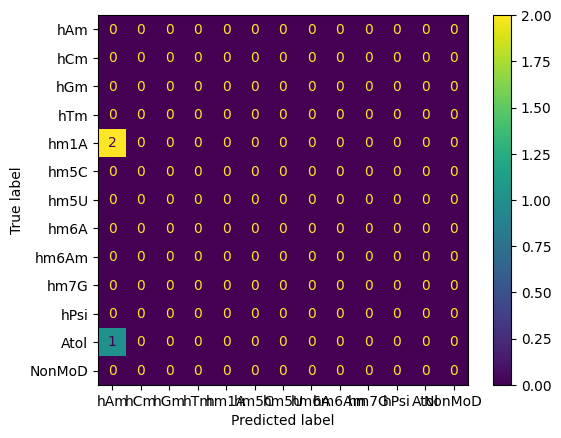

In [27]:
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(np.array(RMs).reshape(-1, 1)) # adding reshape here

original_preds = []
original_labels = []

original_preds.extend(ohe.inverse_transform(one_hot_tensor.cpu().numpy()))  
original_labels.extend(ohe.inverse_transform(labels.cpu().numpy()))

cm = confusion_matrix(original_labels, original_preds, labels=RMs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=RMs)
disp.plot()

original_preds = np.array(original_preds).flatten()
original_labels = np.array(original_labels).flatten()

print(original_preds)
print(original_labels)

class_accuracies = []
for i in RMs:
    class_indices = np.where(np.array(original_labels) == i)
    if len(class_indices[0]) > 0:
        acc = (np.array(original_preds)[class_indices] == i).mean()
    else:
        acc = 0.0
    class_accuracies.append(acc)

validation_accuracy = {}
for rm, acc in zip(RMs, class_accuracies):
    validation_accuracy[rm] = acc

print(validation_accuracy)

